In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import boxcox

# Introduction

Aims: Select features to use in further BN development and look at them in a bit more detail, including:

1) Plot time series

2) Write continuous data for features of interest to csvs

3) Fill NaNs as much as possible and write slices of the data to csv for use in cross validation

4) Test for normality of the features, and transform as needed

Uses results from notebook '02_exploratory_stats' and the feature importance notebooks to pick the features.

# User input

In [4]:
# User input
met_source = "metno"  # Choose one of: 'metno', 'era5'

# File paths to input data
seasonal_features_fpath = (
    r"../Data/DataMatrices/Seasonal_allVars/Vansjø_seasonal_data_1Season_Van2_%s.csv"
    % met_source
)
# Output folders
out_file = r"../Data/DataMatrices"
corr_coeff_folder = r"../Data/CorrelationCoeffs"
graph_outfolder = r"../Figures"

# Read in seasonally-aggregated features

In [5]:
season_df = pd.read_csv(seasonal_features_fpath, index_col=0, parse_dates=True)
season_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,...,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-3.086262,2.848333,NaN,130.0,3.971429,45.250000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,579.570268,13.090170,3.341848,87.710170,86.4,16.080130,43.573016,NaN,NaN,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,244.503965,-0.893721,3.413812,69.853277,NaN,NaN,NaN,NaN,NaN,39.0,...,16.0,33.0,80.0,57.0,27.0,43.573016,NaN,16.08013,13.090170,NaN
1981-10-31,494.730157,12.599971,3.488587,61.463318,NaN,8.331250,28.833333,NaN,NaN,61.0,...,5.0,41.0,68.0,64.0,38.0,43.573016,NaN,16.08013,13.090170,NaN
1982-04-30,366.125943,-1.877038,3.360221,96.428880,69.0,1.100000,46.250000,NaN,NaN,60.0,...,17.0,30.0,68.0,68.0,35.0,28.833333,NaN,8.33125,12.599971,NaN


# Select features and tidy

In [6]:
# Variables to keep
vars_longnames = [
    "chl-a_lake",
    "chl-a_lake_prevSummer",
    "colour_lake",
    "colour_lake_prevSummer",
    "CyanoBiovol",
    "Pptn",
    "TP_lake",
    "TP_lake_prevSummer",
    "Wind_speed",
    "Season",
]

# Dictionary for renaming variable names
var_dict = {
    "chl-a_lake": "chla",
    "chl-a_lake_prevSummer": "chla_prevSummer",
    "colour_lake": "colour",
    "colour_lake_prevSummer": "colour_prevSummer",
    "CyanoBiovol": "cyano",
    "Pptn": "rain",
    "TP_lake": "TP",
    "TP_lake_prevSummer": "TP_prevSummer",
    "Wind_speed": "wind_speed",
    "Season": "season",
}

unchanged_var_names = ["Temp"]

# Drop variables which won't be used in the analysis
df_bn = season_df.loc[:, vars_longnames]

# Rename column names using new short names
for var in df_bn.columns:
    df_bn[var_dict[var]] = df_bn[var]

    # N.B. any variables which have same names in both sides of the dict need to be in this if loop
    if var not in unchanged_var_names:
        df_bn.drop(var, axis=1, inplace=True)

df_bn.tail()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed,season
Date,,,,,,,,,,
2017-04-30,11.000000,9.590909,62.000000,52.0,0.018,307.789680,17.000000,18.750000,3.664088,wint
2017-10-31,12.866667,9.590909,42.000000,52.0,0.258,570.221295,19.666667,18.750000,3.710326,summ
2018-04-30,5.500000,12.866667,71.000000,42.0,0.002,372.847838,24.000000,19.666667,3.439227,wint
2018-10-31,10.741667,12.866667,36.333333,42.0,0.614,312.809003,18.666667,19.666667,3.968478,summ
2019-04-30,4.500000,NaN,59.000000,NaN,0.006,405.441841,22.000000,NaN,3.456906,wint


In [7]:
cont_df = df_bn.loc[df_bn["season"] == "summ", ~df_bn.columns.isin(["season"])]

# Add year column and reindex using year
cont_df["year"] = cont_df.index.year
cont_df.set_index("year", inplace=True)

cont_df.head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
1980,16.080130,NaN,NaN,NaN,NaN,579.570268,43.573016,NaN,3.341848
1981,8.331250,16.08013,NaN,NaN,NaN,494.730157,28.833333,43.573016,3.488587
1982,5.975000,8.33125,26.666667,NaN,NaN,458.474789,26.988095,28.833333,3.818478
1983,6.050000,5.97500,17.625000,26.666667,NaN,466.631052,29.781250,26.988095,4.247283
1984,11.611111,6.05000,NaN,17.625000,NaN,561.472065,27.158333,29.781250,3.796739


# Fill NaNs & make continuous dfs for BN cross validation

Currently the data cover the period 1980-2018/19, but with the following gaps:
- Quite a few gaps in colour:
    * Summer colour: just a couple of missing years, including 1 at the start. **linearly interpolate or backward fill**
    * Winter colour: only have 20 data points. There's a reasonable relationship between summer and winter colour. For now, **fill in the values back to cover the same dates as cyanobacteria using a regression between summer and winter colour**: winter colour = 0.81 colour_summer + 23.8
- All cols 'prevSummer' are missing data in 1980. Therefore: **drop 1980**
- No TP or chl-a data was collected in 1999. Correspondingly, blanks in TP_prevSummer and chla_prevSummer for 2000. **linearly interpolate**.
- **If using met.no data**, only have data up until mid 2019 so **Drop 2019**. Otherwise, keep it in.
- cyanobacteria:
    * if cyano_prevSummer is included as predictor variable, then first year is 1997 and drop all before
    * otherwise, **first year is 1996, drop all before**.
    
For cross validation, can't have NaNs. Don't want to just drop all NaNs though, as have much less cyano data than have TP and chl-a data. Therefore make two different dataframes for cross validation, one for TP and chl-a that includes all years, and excludes cyano. One for cyano and colour. Can't include summer colour in the TP and chl-a one despite having lots of data, because they're linked via cyano. Not sure how valid the cross val will be in this case, as the final network I'll be using will be different to the ones used in cross val... But it's a start anyway. To improve on, need to write own function to allow cross val to be able to cope with missing values.

## Continuous dataframe, all data

In [8]:
# Truncate start and end years
if met_source == 'metno':
    end_yr = 2018
else:
    end_yr = 2019
cont_df = cont_df.loc[1981:2019, :]

# Linearly interpolate gaps of size 1
cont_df.interpolate(method='linear', limit=1, inplace=True)

# Backwards fill summer colour NaNs at start of record (summer colour and previous summer's colour)
for col in ['colour', 'colour_prevSummer']:
    cont_df[col] = cont_df[col].fillna(method='bfill', limit=2)

cont_df.head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,,
1981,8.331250,16.080130,26.666667,26.666667,NaN,494.730157,28.833333,43.573016,3.488587
1982,5.975000,8.331250,26.666667,26.666667,NaN,458.474789,26.988095,28.833333,3.818478
1983,6.050000,5.975000,17.625000,26.666667,NaN,466.631052,29.781250,26.988095,4.247283
1984,11.611111,6.050000,26.014881,17.625000,NaN,561.472065,27.158333,29.781250,3.796739
1985,11.895238,11.611111,34.404762,26.014881,NaN,548.374613,30.957143,27.158333,3.644022


In [9]:
# Check for NaNs
cont_df[['colour','colour_prevSummer']].isna().sum().sum()

0

## Cyano and colour dataframe

In [10]:
# Make cyanobacteria and lake colour dataframe (all data or just nodes directly linked to cyano and colour)

# Drop missing data from start
cont_df_cyano_colour = cont_df.copy().loc[1996:, :]

# Select variables directly involved in cyanobacterial BN
cont_df_cyano_colour_directVars = cont_df_cyano_colour.loc[
    :, ["cyano", "chla", "colour", "colour_prevSummer", "rain"]
]

# Check for NaNs
print("Number of NaNs: %s" % cont_df_cyano_colour.isna().sum().sum())
print("Number of NaNs: %s" % cont_df_cyano_colour_directVars.isna().sum().sum())

# cont_df_cyano_colour.head()
cont_df_cyano_colour_directVars.head()

Number of NaNs: 0
Number of NaNs: 0


,cyano,chla,colour,colour_prevSummer,rain
year,,,,,
1996,4.80,21.300000,17.666667,25.833333,449.609513
1997,2.82,23.066667,19.000000,17.666667,420.429376
1998,2.28,21.100000,34.711538,19.000000,519.280270
1999,5.96,21.633333,50.423077,34.711538,630.476421
2000,4.67,22.166667,42.560000,50.423077,617.658010


## TP and chl-a dataframe

In [11]:
# Drop cyanobacteria from TP and chl-a dataframe
cont_df_noCyano = cont_df.drop(['cyano'], axis=1)

# Backwards fill summer colour NaNs
cont_df_noCyano.fillna(method='bfill', limit=2, inplace=True)

# Check for NaNs
print('Number of NaNs: %s' % cont_df_noCyano.isna().sum().sum())
cont_df_noCyano.tail()

Number of NaNs: 0


,chla,chla_prevSummer,colour,colour_prevSummer,rain,TP,TP_prevSummer,wind_speed
year,,,,,,,,
2014,12.600000,14.138462,41.863636,60.223077,626.732204,20.300000,22.992308,3.519890
2015,14.925000,12.600000,52.833333,41.863636,686.892707,24.250000,20.300000,3.771196
2016,9.590909,14.925000,52.000000,52.833333,408.035955,18.750000,24.250000,3.755978
2017,12.866667,9.590909,42.000000,52.000000,570.221295,19.666667,18.750000,3.710326
2018,10.741667,12.866667,36.333333,42.000000,312.809003,18.666667,19.666667,3.968478


## Continuous dfs to csv

In [12]:
# cont_df.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_all.csv' %met_source))
# cont_df_cyano_colour.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_allVars.csv' %met_source))
# cont_df_cyano_colour_directVars.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_cyanoColour_directVars.csv' %met_source))
# cont_df_noCyano.to_csv(os.path.join(out_file, 'forCrossValidation/Untransformed/%s/Vansjo_Seasonal_6M_Continuous_noCyano.csv' %met_source))

# Test for normality, transform as necessary, write transformed data to csv

For continuous BNs in bnlearn, all nodes are assumed to be Gaussian. Lets see how appropriate this is.

Firstly, plot histograms, then do normality test. From a look at the histograms, most aren't far off bell-shaped, aside from cyanobacteria and colour.

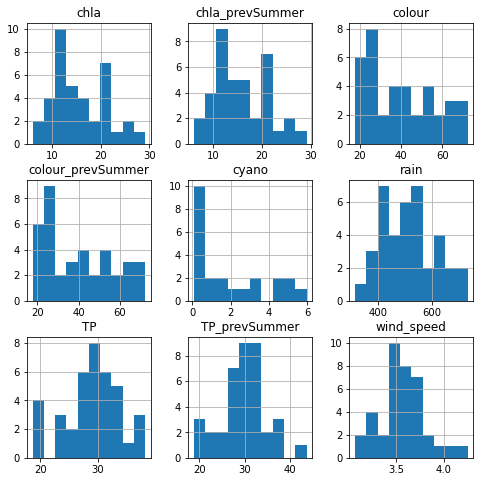

In [13]:
cont_df.hist(figsize=(8, 8));

## Cyano
For cyanobacteria, the distribution is right-skewed and has lots of zeros. In reality these won't really be zeros, just below the counting detection limit. So some kind of transformation is required which can cope with zeros.

Find a box cox transformation works ok:

 y* = (y^L - 1)/L
 
where L != 0. L close to 0 is a near-logorithmic transformation. From some trial and error, find that lambda (L) between 0.06 and 0.2 produces roughly symmetrical data. Doesn't look  bell shaped, but that could easily be because of the low n. No reason to pick any particular number between 0.06 and 0.2, so decide to go with 0.1 as an even number.

Will then need to back-transform the predictions later: y = (x*lambda + 1)^(1/lambda)

<AxesSubplot:>

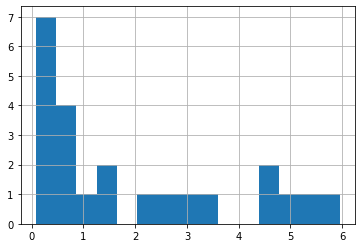

In [14]:
# Original data
cont_df['cyano'].hist(bins=15)

<AxesSubplot:>

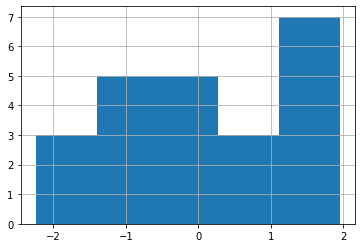

In [15]:
# Try box cox
bs = boxcox(cont_df["cyano"].values, lmbda=0.1)

trans_df = pd.DataFrame(index=cont_df.index)
trans_df["original"] = cont_df["cyano"]
trans_df["boxcox"] = bs

trans_df["boxcox"].hist(bins=5)

In [21]:
def normal_test(series):
    x = series.dropna().values
    k2, p = stats.normaltest(x)
    alpha = 0.05
    print("p(H0) = %s" %p)
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected, x is not normal")
    else:
        print("No evidence to reject the null hypothesis, x is probably normal")

In [22]:
# Test untransformed data for normality
for var in cont_df.columns:
    print("%s: " % var)
    normal_test(cont_df[var])

chla: 
p(H0) = 0.4612578281604316
No evidence to reject the null hypothesis, x is probably normal
chla_prevSummer: 
p(H0) = 0.552299600810064
No evidence to reject the null hypothesis, x is probably normal
colour: 
p(H0) = 0.03529613209701317
The null hypothesis can be rejected, x is not normal
colour_prevSummer: 
p(H0) = 0.025177885166141934
The null hypothesis can be rejected, x is not normal
cyano: 
p(H0) = 0.13491815658822867
No evidence to reject the null hypothesis, x is probably normal
rain: 
p(H0) = 0.5816747130229706
No evidence to reject the null hypothesis, x is probably normal
TP: 
p(H0) = 0.5188289420294979
No evidence to reject the null hypothesis, x is probably normal
TP_prevSummer: 
p(H0) = 0.48925512225593837
No evidence to reject the null hypothesis, x is probably normal
wind_speed: 
p(H0) = 0.26425825238561795
No evidence to reject the null hypothesis, x is probably normal


In [23]:
# Test transformed cyanobacteria data for normality
normal_test(trans_df['boxcox'])

p(H0) = 0.03828060668535506
The null hypothesis can be rejected, x is not normal


Cyanobacteria data did not fail the normality test even before transformation, due to lack of data. However, the histogram is clearly not normal-shaped, so I think I am going to go with the box cox transformation anyway for starters.

## Write transformed data to csvs

In [24]:
# Copy original dfs, transform and write to csv
df_dict = {
    "all": cont_df,
    "cyanoColour_allVars": cont_df_cyano_colour,
    "cyanoColour_directVars": cont_df_cyano_colour_directVars,
}
keyLi = list(df_dict.keys())

for key in keyLi:
    df_boxcx = df_dict[key].copy()
    # Apply transformation
    for col in ["cyano"]:
        df_boxcx[col] = boxcox(df_boxcx[col].values, lmbda=0.1)

    # Save to csv
    pathname = os.path.join(
        out_file,
        "forCrossValidation/Transformed/%s/Vansjo_6M_Continuous_%s_boxcox.csv"
        % (met_source, key),
    )
    df_boxcx.to_csv(pathname)